<a href="https://colab.research.google.com/github/waltechel/tensorflow-ml-nlp-tf2/blob/master/7.PRETRAIN_METHOD/chapter07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# chapter07 사전학습 모델

- 하위 문제 : 사전 학습한 가중치를 활용해 학습하고자 하는 본 문제
- 사전 학습 : 최초로 생성된 모델의 가중치를 임의의 값으로 초기화하는 것이 아니라 사전에 학습된 가중치를 활용하는 방식이다. 
- 사전 학습한 가중치를 활용하는 방법
  1. 특징 기반 방법 : 사전 학습된 특징을 하위 문제의 모델에 부가적인 특징으로 활용하는 방법
  2. 미세 조정(fine - tunning) : 하위 문제를 위한 최소한의 가중치를 추가해서 모델을 추가로 학습하는 모델이다. 

## 01 버트

- 버트 : 구글 논문 `<BERT : Pre-training of Deep Bidirectional Transformers for Language UnderStanding>`에서 제안된 모델 
- 버트의 경우 사전학습하는 모델이 양방향성을 띈다는 점이 GPT, ELMo와의 차이점이다.

#### 버트의 사전 학습 문제

- 언어 모델
  - 단어들의 시퀀스에 대한 확률 분포
- 언어 모델의 목적 함수
  - 사례 > CBOW 모델의 목적 함수

  $$ logp(W_t|W_{t-c}, W_{t-c+1}, ... , W_{t-1}, W_{t+1}, ... , W_{t+c-1}, W_{t+c} ) $$

- 버트는 2개의 문제를 사전 학습한다. 
  1. 마스크 언어 모델(MLM) :  Masked Language Model
  2. 다음 문장 예측(NSP) : Next Sentence Prediction

#### 버트의 모델

- 트랜스포머 모델의 전체를 사용하는 것이 아니라 인코더 부분만 사용해 모델을 학습한다
- 트랜스포머
  - CNN, RNN을 쓰지 않고 오직 Linear 레이어와 Attention만 사용하여 자연어 처리 태스크를 수행한다
  - 시간 순으로 나열된 토큰이 순차적으로 입력되지 않고 모두 한번에 입력되고 처리된다.

- 그림

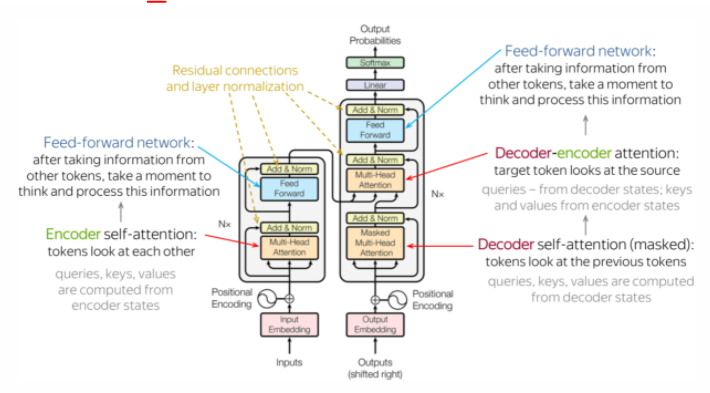

- 인코더 : 인코더를 통해서 문서를 이해했는데, 버트는 인코더만 활용하므로, 
- GPT는 디코더로만 이루어져 있고, BERT는 인코더로만 이루어져 있다. 


#### 버트의 미세 조정

- 사전 학습한 BERT 모델을 MNLI, NER, SQuAD 라는 자연어 처리 하위 문제에 미세 조정할 수 있었다.


#### 이후 과제
- 언어적 용인 가능성 : 그는 한번도 고향에 갔다 -> 불가능 판정
- 자연어 추론
  - 전제 : 버트를 이용한 자연어 처리를 수행하는 연구자가 사무실에 있다
  - 가설 : 연구자는 딥러닝을 알지 못한다
  - 답 : 모순
- 유사도 예측
  - 입력 1 : 버트와 트랜스포머 중에 무엇을 먼저 알아야 할까요?
  - 입력 2 : Bert와 Transformer 중에 무엇을 먼저 알아야 할까요?
  - 답 : 유사
- 감정 분석
  - 입력 : 나는 이 영화를 용서한다
  - 답 : 부정
- 개체명 인식 
  - 입력 : 단백질은 단 한 가지 아미노산이라도 부족하면 합성되지 않는다
  - 답 : 단백질(BIO), 아미노산(BIO)
- 기계독해
  - 입력 : ~~~~~ 수많은 문장, 문서 ~~~~~~
  - 질문 : 이순신의 외가는?
  - 답 : 아산

## 02 버트를 활용한 미세 조정 학습

- 허깅페이스의 라이브러리를 활용하기 위해 트랜스포머 설치한다.

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

- 트랜스포머는 한번 설치후에 런타임을 재시작해주어야 한다.
- 재시작하는 것은 설치를 했으니까 설치가 제대로 먹도록 만들어주는 것이다. 세션을 자르는 것과는 다르다.

#### 버트 파일 불러오기


In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

#### 버트 문장 전처리 정리하기 


- 문장을 토크나이징한다
- 토큰의 시작점에 [cls] 토큰, 토큰의 마지막에 [sep] 토큰을 붙인다.
- 각 토큰을 인덱스로 반환한다
- 최대 길이에 맞추어 패딩을 진행하거나, 글자를 잘라낸다
- return_attention_mask 기능을 통해 어텐션 마스크를 생성한다
- 토큰 타입은 문장이 1개일 경우 0으로, 문장이 2개일 경우 0과 1로 구분해서 생성한다.

In [ ]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

### 버트를 활용한 한국어 텍스트 분류 모델 


#### 네이버 영화 리뷰 데이터 전처리 

In [ ]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

In [ ]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

- 해당 다국어 토크나이저와 encode_plus 기능을 활용해 영화 리뷰 데이터를 전처리해보자.

- \data_in\KOR\naver_movie 경로에 데이터를 갖다 놓는다.

In [ ]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

In [ ]:
len(train_data)

- 꽤 많은 시간이 든다. 그래서 데이터의 개수를 만 개로 줄여 냈다.
- 만 개는 한 에폭 당 1시간 30분 정도 소요된다
- 그래서 데이터의 개수를 조금 더 줄여서 천 개로 줄여 냈다

In [ ]:
train_data = train_data[:1000]

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["document"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

- 전체 문장 중 하나를 추출해서 출력해본다.
- 결괏값을 보면 각 문장이 단어의 부분 단위로 쪼개져서 각 숫자에 인덱스 처리된 것을 볼 수 있으며, 해당 문장은 전처리를 진행할 때 최대 길이보다 작기 때문에 뒤에 0으로 패딩된 것을 알 수 있다.

In [ ]:
# 최대 길이: 39
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

# tokenizing된 아이디
print(input_id)
# attention mask : 볼 것인지 안 볼 것인지를 결정 
# 마스킹된 데이터는 확인하지 않는다. 맨 마지막에 0으로 주는 이유는 패딩을 굳이 집중할 필요가 없기 때문이다.
# [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
print(attention_mask)
# bert에서만 token_type_id를 사용. 문장을 구분하는 역할
# 첫 번째 문장은 0, 두 번째 문장은 1로 채워지는 것
# 이후 사용되지 않는 이유는 [SEP] 토큰을 사용하는 것으로 갈음할 수 있기 때문
print(token_type_id)
# 디코더로 디코딩하는 부분. [SEP] [PAD] 가 대소문자 중 어떤 스타일인지 체크할 필요가 있다
print(tokenizer.decode(input_id))

#### 네이버 영화 리뷰 모델 학습


- 학습을 준비하기 위해 버트 분류 클래스를 구성하고, 최적화, 손실값 및 정확도를 선언하고 학습을 진행하기 위한 compile을 진행한다.

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        # 여기 부분을 CNN으로 구현하여 맨 마지막에 합칠 수도 있다
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

# 감성 분석 데이터에서는 정답의 수는 2개로 나뉜다. 
cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

- 아담 최적화, 크로스엔트로피 손실값 측정, 모델의 정확도를 측정한다.


In [ ]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy') # 고유명사가 많을 때는 F1-score
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

- gpu 학습이 필요한 부분이다.
- ~~data_out 폴더를 만들어야 한다.~~ 만들지 않아도 된다
- 검증 데이터를 기반으로 해당 데이터는 약 3에폭 학습했을 때 좋은 성능을 내는 것을 확인할 수 있다.

In [ ]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 earlystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

#### 네이버 영화 리뷰 모델 테스트

In [ ]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

- 테스트 데이터 너무 많아서 500개로 줄여냈다.

In [ ]:
len(test_data)

In [ ]:
test_data = test_data[:500]

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

In [ ]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

### 버트를 활용한 한국어 자연어 추론 모델


- 카카오브레인에서 공개한 새로운 한국어 벤치마크 셋인 KorNLI 데이터
- 카카오브레인 사랑합니다!

#### KorNLI 데이터 분석


- KorNLI 깃허브 저장소 
  - https://github.com/kakaobrain/KorNLUDatasets

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

In [ ]:
DATA_IN_PATH = './data_in/KOR'

- 판다스를 통해 파일을 불러와보자
- 데이터프레임의 head(10)을 보면 두 개의 값 sentence1과 sentence2는 각각 첫번째 문장과 두번째 문장을 의미하며, gold_label은 해당 문장의 정답을 의미한다.

In [ ]:
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')

multinli_data = pd.read_csv(TRAIN_XNLI_DF, sep='\t', error_bad_lines=False)
multinli_data.head(10)

In [ ]:
print('전체 multinli_data 개수: {}'.format(len(multinli_data)))

In [ ]:
train_data = pd.concat([multinli_data, snli_data], axis=0)
train_data.head(10)

- 데이터의 개수가 무려 935,646이 된다.
- 지금보다는 더 좋은 장비가 필요하다. 그리고 분석이나 학습 시 시간이 많이 필요하게 되었다.

In [ ]:
print('전체 train_data 개수: {}'.format(len(train_data)))

- 이것 역시 테스트의 목적으로 데이터를 조금 줄여내도록 한다.

In [ ]:
train_data = train_data[:1000]

- 문장 1과 문장 2를 합친다.


In [ ]:
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
train_set.head()

- 합친 문장의 데이터의 개수 : 1,871,292


In [ ]:
print('전체 문장 데이터의 개수: {}'.format(len(train_set)))

- 데이터 파악을 위해 중복된 문장도 찾아보고
- 시각화를 해본다.

In [ ]:
print('유일한 총 문장 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 문장의 수: {}'.format(np.sum(train_set.value_counts() > 1)))

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of sentence appearance counts')
# 그래프 x 축 라벨
plt.xlabel('Number of occurrences of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [ ]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제 3 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

In [ ]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([train_set.value_counts()],
             labels=['counts'],
             showmeans=True)

- 버트 토크나이저를 호출한다. 

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

In [ ]:
train_length = train_set.apply(len)

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Distribution of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [ ]:
print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

In [ ]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

- 워드 클라우드까지 확인해본다

In [ ]:
from wordcloud import WordCloud

font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 3)
sns.countplot(train_data['gold_label'])

#### KorNLI 데이터 전처리


In [ ]:
import os
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정

tf.random.set_seed(1234)
np.random.seed(1234)

# BASE PARAM

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 24 * 2 # Average total * 2

DATA_IN_PATH = './data_in/KOR'
DATA_OUT_PATH = "./data_out/KOR"

In [ ]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna()
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

- Bert Tokenizer와는 차이가 있다고 한다.

In [ ]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two setenece input
    
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
train_snli_xnli_input_ids = np.array(input_ids, dtype=int)
train_snli_xnli_attention_masks = np.array(attention_masks, dtype=int)
train_snli_xnli_type_ids = np.array(token_type_ids, dtype=int)
train_snli_xnli_inputs = (train_snli_xnli_input_ids, train_snli_xnli_attention_masks, train_snli_xnli_type_ids)

- 이전과 같이 패딩된 것을 알 수 있다

In [ ]:
input_id = train_snli_xnli_input_ids[2]
attention_mask = train_snli_xnli_attention_masks[2]
token_type_id = train_snli_xnli_type_ids[2]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

In [ ]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_xnli_input_ids = np.array(input_ids, dtype=int)
dev_xnli_attention_masks = np.array(attention_masks, dtype=int)
dev_xnli_type_ids = np.array(token_type_ids, dtype=int)
dev_xnli_inputs = (dev_xnli_input_ids, dev_xnli_attention_masks, dev_xnli_type_ids)

In [ ]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

#### KorNLI 모델 학습


- 이전과 거의 비슷한데 다만 현재 값은 이진 분류가 아닌 다중 분류이기 떄문에 num_labels의 값을 라벨의 수만큼 변환한다는 차이가 있다.

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=3)

 - 아담, 크로스엔트로피, accuracy

In [ ]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
#학습 진행하기
model_name = "tf2_KorNLI"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_snli_xnli_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_xnli_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

#### KorNLI 모델 테스트


- 학습된 모델을 활용해 테스트를 진행해보자

In [ ]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
test_data_xnli = test_data_xnli.dropna()
test_data_xnli.head()

In [ ]:
# Test set도 똑같은 방법으로 구성한다.

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(sent1, sent2, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
    
test_xnli_input_ids = np.array(input_ids, dtype=int)
test_xnli_attention_masks = np.array(attention_masks, dtype=int)
test_xnli_type_ids = np.array(token_type_ids, dtype=int)
test_xnli_inputs = (test_xnli_input_ids, test_xnli_attention_masks, test_xnli_type_ids)

In [ ]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_xnli_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_xnli_input_ids), len(test_data_xnli_labels)))

In [ ]:
results = cls_model.evaluate(test_xnli_inputs, test_data_xnli_labels, batch_size=512)
print("test loss, test acc: ", results)

### 버트를 활용한 한국어 개체명 인식 모델


- 개체명 인식은 문맥을 파악해서 인명, 기관명, 지명 등과 같은 문장 또는 문서에서 특정한 의미를 가지고 있는 단어 또는 어구를 인식하는 과정을 의미한다.

#### NER 데이터 분석


- 데이터는 Naver NLP Challenge 2018의 개체명 인식 데이터를 활용해보자

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

#### 데이터 불러오기



- 이것도 NER 폴더를 넣어야 한다.

In [ ]:
# 데이터 불러오기
DATA_IN_PATH = 'data_in/KOR'
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")

- 문장 분석을 위해 데이터의 위치를 지정한 후, 학습 데이터와 테스트 데이터를 각각 리스트 형태로 저장하고 두 데이터를 합치는 과정을 진행한다.

In [ ]:
def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels
    
train_sentences, train_labels = read_file(DATA_TRAIN_PATH)
test_sentences, test_labels = read_file(DATA_TEST_PATH)
ner_sentences = train_sentences + test_sentences
ner_labels = train_labels + test_labels

ner_dict = {"sentence": ner_sentences, "label": ner_labels}
ner_df = pd.DataFrame(ner_dict)

In [ ]:
print('전체 ner_data 개수: {}'.format(len(ner_df)))

- 개체명 인식 데이터 라벨
  - PER
  - FLD
  - AFW : 인공물
  - ORG
  - LOC
  - CVL
  - DAT
  - TIM
  - NUM
  - EVT
  - ANM : 동물
  - PLT : 식물
  - MAT : Material
  - TRM : 일반용어(Term)
  - O : Outside. 개체명이 아닌 부분

#### 한국어 개체명 텍스트 분석


In [ ]:
train_set = pd.Series(ner_df["sentence"].tolist())
print('유일한 총 문장 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 문장의 수: {}'.format(np.sum(train_set.value_counts() > 1)))

In [ ]:
train_length = train_set.apply(len)

In [ ]:
train_set[0]

In [ ]:
print('문장 길이 최대 값: {}'.format(np.max(train_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('문장 길이 중간 값: {}'.format(np.median(train_length)))
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))
print('문장 길이 99%: {}'.format(np.percentile(train_length, 99)))

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Distribution of character count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [ ]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

In [ ]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

# 문장 단어 개수 최대 값: 175
# 문장 단어 개수 평균 값: 11.81
# 문장 단어 개수 표준편차: 7.03
# 문장 단어 개수 중간 값: 10.0
# 문장 단어 개수 제 1 사분위: 7.0
# 문장 단어 개수 제 3 사분위: 15.0
# 문장 단어 개수 99 퍼센트: 35.0

In [ ]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

#### NER 데이터 전처리


In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [ ]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

# 개체명 인식 학습 데이터 개수: 81000
# 개체명 인식 테스트 데이터 개수: 9000

In [ ]:
# Label 불러오기

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))

- 다음은 버트 토크나이저를 설정하고 버트에 필요한 각 토큰 값을 설정하는 과정이다. 

In [ ]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

In [ ]:
# 버트 토크나이저를 통한 학습 데이터를 손쉽게 학습할 수 있도록 bert_tokenizer를 생성한다.
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id


- 띄어쓰기 단위의 라베을 토큰 단위로 변환하는 함수를 구성해본다. 

In [ ]:
def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
            
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        
        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
  
    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    return label_ids

In [ ]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    # 각 데이터프레임에 있는 문장과 라벨을 띄어쓰기 단위로 만들어 각각 words와 labels 변수에 저장한다.
    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
        # labels_idx에 labels의 값들을 인덱스로 변환한다. 
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

        assert len(words) == len(labels_idx)

        # 버트에 필요한 것들을 생성하는 과정과 같다.
        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        # 앞에서 설명한 띄어쓰기 단위의 라벨을 토큰 단위로 변환하는 함수를 호출해서 라벨 토큰 단위로 변환한다.
        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

# 넘파이 형태로 치환해서 각 형태에 맞게 반환한다.
train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

#### NER 모델 학습 및 테스트


In [ ]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
                
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        
        return logits

- 현재 개체명 인식 모델은 문장을 토큰화해서 각각 한개의 토큰에 대한 라벨이 있어 각각을 전부 분류해야 하는 시퀀스 라벨 문제가 생겼다.

In [ ]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

- 이번에는 손실 값을 확인해보자. 개체명 분류는 시퀀스 분류이기 때문에 기존과 다르게 직접 손실 값 함수를 구현하여야 한다.

In [ ]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    active_loss = tf.reshape(labels, (-1,)) != 0
        
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
        
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    
    return loss_fn(labels, reduced_logits)

- 이번에는 accuracy를 사용하기 힘들기 때문에 F1 score를 사용한다.

In [ ]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
        
    def on_epoch_end(self, epoch, logs=None):

        results = {}
        
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])
                    
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

- 이후는 직접 제작한 손실값 함수와 옵티마이저 및 학습 메트릭을 설정한 후 컴파일을 진행한다.


In [ ]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [ ]:
model_name = "tf2_bert_ner"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

- 최종적으로 학습을 완료한 후 에폭마다 학습 데이터의 손실 값을 구한 결과는 다음과 같다.

In [ ]:
plot_graphs(history, 'loss')

### 버트를 활용한 한국어 텍스트 유사도 모델


#### STS 데이터 분석


### 버트를 활용한 한국어 기계 독해 모델


#### KorQuAD 1.0 데이터분석



#### KorQuAD 1.0 데이터 전처리


#### KorQuAD 1.0 학습 및 테스트


## 03 GPT


### GPT1


### GPT2

## 04 GPT2를 활용한 미세 조정 학습


### GPT2를 활용한 한국어 언어 생성 모델 


#### 사전 학습 모델 문장 생성


#### 소설 텍스트 데이터 전처리하기


#### 소설 텍스트 미세 조정 모델 학습


#### 미세 조정 학습 결과 확인


### GPT2를 활용한 한국어 텍스트 분류 모델


#### 네이버 영화 리뷰 데이터 전처리

#### 네이버 영화 리뷰 모델 학습


#### 네이버 영화 리뷰 모델 테스트


### GPT2를 활용한 한국어 자연어 추론 모델


#### KorNLI 데이터 전처리


#### KorNLI 모델 학습


#### KorNLI 모델 테스트


### GPT2를 활용한 한국어 텍스트 유사도 모델


#### KorSTS 데이터 전처리


#### KorSTS 모델 학습


#### KorSTS 모델 테스

## 05 정리